## Housekeeping (library installation/setup)

In [64]:
!pip install scanpy anndata dca leidenalg deepimpute

  Created wheel for deepimpute: filename=deepimpute-1.2-cp37-none-any.whl size=10192 sha256=4b60ebc5eec65b85bfc2def0933505a5b09c5e240b581bb4117c244b01121eaa
  Stored in directory: /root/.cache/pip/wheels/25/ab/5e/2eb8736cbd98198f212def7fdfaf611ff33407b64f8820a2e7
Successfully built deepimpute


# Main stuff here:

3k PBMC dataset, which is used in scanpy's tutorial

In [ ]:
!tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz 

tar (child): pbmc3k_filtered_gene_bc_matrices.tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now


68k PGMC dataset from Donor A, which is one dataset used in the main DCA paper

In [ ]:
!tar -xzf fresh_68k_pbmc_donor_a_filtered_gene_bc_matrices.tar.gz

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import anndata

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
from torch.autograd import Variable
import matplotlib.pyplot as plt

In [ ]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (5, 4)

## Data preparation
Data takes in the form of a csv that represents the cell count matrix

In [ ]:
# Sample data loading from a matrix file - 3k PBMCs
#adata = sc.read_10x_mtx(
#    'filtered_gene_bc_matrices/hg19/',  
#    var_names='gene_symbols',                
#    cache=False)          

# Sample data from 68k PBMCs     
adata = sc.read_10x_mtx(
    'filtered_matrices_mex/hg19/',  
    var_names='gene_symbols',                
    cache=False)                 

In [ ]:
total_sample_size = adata.n_obs
total_sample_size

68579

In [ ]:
indices = np.random.choice(total_sample_size, size=8000, replace=False).tolist()

In [ ]:
adata = adata[indices, ]

In [ ]:
adata

View of AnnData object with n_obs × n_vars = 8000 × 32738
    var: 'gene_ids'

In [ ]:
adata.var_names_make_unique()

In [ ]:
# Do preprocessing on the raw count matrix
sc.pp.filter_genes(adata, min_counts=1)
sc.pp.filter_cells(adata, min_counts=1)

adata.raw = adata.copy()

sc.pp.normalize_total(adata, inplace=True)
adata.obs['size_factors'] = adata.obs.n_counts / np.median(adata.obs.n_counts)

sc.pp.log1p(adata)
sc.pp.scale(adata)

In [ ]:
adata.obs['size_factors'].shape

(8000,)

In [ ]:
adata.X

array([[-0.03475815, -0.01118034, -0.04081826, ..., -0.01118034,
        -0.16056976, -0.14951098],
       [-0.03475815, -0.01118034, -0.04081826, ..., -0.01118034,
        -0.16056976, -0.14951098],
       [-0.03475815, -0.01118034, -0.04081826, ..., -0.01118034,
        -0.16056976,  6.294798  ],
       ...,
       [-0.03475815, -0.01118034, -0.04081826, ..., -0.01118034,
        -0.16056976, -0.14951098],
       [-0.03475815, -0.01118034, -0.04081826, ..., -0.01118034,
        -0.16056976, -0.14951098],
       [-0.03475815, -0.01118034, -0.04081826, ..., -0.01118034,
        -0.16056976, -0.14951098]], dtype=float32)

In [ ]:
n_cells, n_genes = adata.n_obs, adata.n_vars
print('# of cells: ', n_cells)
print('# of genes: ', n_genes)

# of cells:  8000
# of genes:  16632


In [ ]:
adata.raw.X.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
count_mtx = torch.tensor(adata.X)
size_factor = torch.tensor(adata.obs.size_factors.values)
count_mtx_raw = torch.tensor(adata.raw.X.toarray())

In [ ]:
dataset = TensorDataset(count_mtx, size_factor, count_mtx_raw)

In [ ]:
train_dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

Iterate through dataloader

In [ ]:
sample = next(iter(train_dataloader))
inp, size_fact, out = sample
print("INP\n", inp.shape)
print("Size fact\n", size_fact.shape)
print("OUT\n", out.shape)


INP
 torch.Size([32, 16632])
Size fact
 torch.Size([32])
OUT
 torch.Size([32, 16632])


## Model and loss implementations

### Custom activations for the mean and dispersion layers. Pi layer will simply use a sigmoid, since it represents a probability

In [3]:
class mean_activation(nn.Module):
  def __init__(self):
    super(mean_activation, self).__init__()

  def forward(self, input):
    exp = torch.exp(input)
    exp = torch.clip(exp, 1e-5, 1e6)
    return exp

class disp_activation(nn.Module):
  def __init__(self):
    super(disp_activation, self).__init__()

  def forward(self, input):
    theta = nn.functional.softplus(input)
    theta = torch.clip(theta, 1e-4, 1e4)
    return theta

### Here is the model definition for a very simple autoencoder structure

In [4]:
class ZINB_Autoencoder(nn.Module):
  def __init__(self, n_genes, hidden_dims, activation='relu'):
    super(ZINB_Autoencoder, self).__init__()

    self.n_genes = n_genes

    # Assume a 3 layer architecture for the autoencoder
    self.autoencoder_stack = nn.Sequential(
        nn.Linear(n_genes, hidden_dims[0]),
        nn.BatchNorm1d(hidden_dims[0], eps=0.001, affine=False),
        nn.ReLU(),
        nn.Linear(hidden_dims[0], hidden_dims[1]),
        nn.BatchNorm1d(hidden_dims[1], eps=0.001, affine=False),
        nn.ReLU(),
        nn.Linear(hidden_dims[1], hidden_dims[2]),
        nn.BatchNorm1d(hidden_dims[2], eps=0.001, affine=False),
        nn.ReLU()
    )

    self.mean = nn.Sequential(
        nn.Linear(hidden_dims[2], n_genes),
        #nn.BatchNorm1d(n_genes),
        mean_activation()
    )

    self.theta = nn.Sequential(
        nn.Linear(hidden_dims[2], n_genes),
        #nn.BatchNorm1d(n_genes),
        disp_activation()
    )
    self.pi = nn.Sequential(
        nn.Linear(hidden_dims[2], n_genes),
        #nn.BatchNorm1d(n_genes),
        nn.Sigmoid()
    )

  def forward(self, input, size_factor):
    size_factor = size_factor.view(-1, 1)
    size_factor = size_factor.repeat(1, n_genes)

    #ae_out = input * size_factor

    ae_out = self.autoencoder_stack(input)

    mean = self.mean(ae_out) * size_factor
    theta = self.theta(ae_out)
    pi = self.pi(ae_out)

    return mean, theta, pi


In [5]:
def weights_init(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

### Here is the loss function
Defined as the likelihood of seeing input x given a ZINB parameterized with network outputs 'mean', 'theta', and 'pi'

In [6]:
class ZINB_Loss(nn.Module):
  def __init__(self):
    super(ZINB_Loss, self).__init__()
    self.eps = 1e-10

  # y_true is the input data (i.e. observed gene counts per cell)
  # the loss is the likelihood that we see the input_data given a ZINB parameterized by y_pred (mean, theta, pi)
  # we translate this into a negative log-likelihood for easier computation and for gradient methods
  def forward(self, mean, theta, pi, y_true): 

    # Clipping (as in DCA code)
    theta = torch.where(theta < 1e6, theta, torch.full_like(theta, 1e6))

    # zero case
    zero_case = (1.0 - pi) * torch.pow( (theta + self.eps) / (mean + theta + self.eps), theta) 
    zero_case = -torch.log(zero_case + pi)

    # nonzero case
    nonzero_case_1 = -torch.log(1 - pi)
    nonzero_case_2 =  torch.lgamma(theta + self.eps) + torch.lgamma(y_true + 1.0) - torch.lgamma(theta + y_true + self.eps) # negative already applied
    nonzero_case_3 = (theta + y_true) * torch.log(1.0 + (mean / (theta + self.eps))) + (y_true * (torch.log(theta + self.eps) - torch.log(mean + self.eps))) # negative applied here
    #nonzero_case_3 = theta * torch.log( theta / (mean + theta) ) + y_true * torch.log( mean / (mean + theta) )
    nonzero_case = nonzero_case_1 + nonzero_case_2 + nonzero_case_3

    # multiplex between zero and nonzero case vectors based on whether y_true is zero or not
    ## Question on whether condition should account for float rounding or not (for now YES)
    loss = torch.where(y_true < 1e-8, zero_case, nonzero_case)

    loss = loss.mean()

    return loss



## Model training

In [ ]:
learning_rate = 1e-3
batch_size = 32
epochs = 50
grad_clip_val = 5.0

In [ ]:
model = ZINB_Autoencoder(n_genes, (64, 32, 64))
model.apply(weights_init)

ZINB_Autoencoder(
  (autoencoder_stack): Sequential(
    (0): Linear(in_features=16632, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=0.001, momentum=0.1, affine=False, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): BatchNorm1d(32, eps=0.001, momentum=0.1, affine=False, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=64, bias=True)
    (7): BatchNorm1d(64, eps=0.001, momentum=0.1, affine=False, track_running_stats=True)
    (8): ReLU()
  )
  (mean): Sequential(
    (0): Linear(in_features=64, out_features=16632, bias=True)
    (1): mean_activation()
  )
  (theta): Sequential(
    (0): Linear(in_features=64, out_features=16632, bias=True)
    (1): disp_activation()
  )
  (pi): Sequential(
    (0): Linear(in_features=64, out_features=16632, bias=True)
    (1): Sigmoid()
  )
)

In [ ]:
zb_loss_fn = ZINB_Loss()

optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, epochs / 2)

In [34]:
def train_loop(dataloader, model, loss_fn, optimizer):
  size_data = len(dataloader.dataset)
  for batch, (X, size, y) in enumerate(dataloader):
    optimizer.zero_grad()

    # Predict, and calculate loss
    mean, theta, pi = model(X, size)
    loss = loss_fn(mean, theta, pi, y)

    # Backprop
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), grad_clip_val)
    optimizer.step()

    if batch % 50 == 0:
      loss, curr = loss, batch * len(X)
      print(f"loss: {loss} for batch {curr}/{size_data}")

In [ ]:
for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train_loop(train_dataloader, model, zb_loss_fn, optimizer)

  scheduler.step()

Epoch 1
-------------------------------
loss: 0.3308996260166168 for batch 0/8000
loss: 0.11995745450258255 for batch 1600/8000
loss: 0.11852456629276276 for batch 3200/8000
loss: 0.12290403246879578 for batch 4800/8000
loss: 0.10935752093791962 for batch 6400/8000
Epoch 2
-------------------------------
loss: 0.1283518373966217 for batch 0/8000
loss: 0.1146370992064476 for batch 1600/8000
loss: 0.11180668324232101 for batch 3200/8000
loss: 0.10536859184503555 for batch 4800/8000
loss: 0.11536857485771179 for batch 6400/8000
Epoch 3
-------------------------------
loss: 0.1124660074710846 for batch 0/8000
loss: 0.11092004925012589 for batch 1600/8000
loss: 0.11266670376062393 for batch 3200/8000
loss: 0.11328316479921341 for batch 4800/8000
loss: 0.12013256549835205 for batch 6400/8000
Epoch 4
-------------------------------
loss: 0.11156249791383743 for batch 0/8000
loss: 0.1140337884426117 for batch 1600/8000
loss: 0.11806195229291916 for batch 3200/8000
loss: 0.10796292126178741 for

#### Here is the sample output for the original count matrix

In [ ]:
mean, theta, pi = model(count_mtx, size_factor)

In [ ]:
mean

tensor([[0.0183, 0.0118, 0.0230,  ..., 0.0083, 0.0709, 0.0887],
        [0.0278, 0.0087, 0.0419,  ..., 0.0184, 0.0894, 0.1254],
        [0.0178, 0.0140, 0.0251,  ..., 0.0075, 0.0815, 0.1052],
        ...,
        [0.0230, 0.0088, 0.0141,  ..., 0.0074, 0.0655, 0.1021],
        [0.0170, 0.0066, 0.0094,  ..., 0.0039, 0.0438, 0.0404],
        [0.0216, 0.0039, 0.0278,  ..., 0.0120, 0.0529, 0.0775]],
       grad_fn=<MulBackward0>)

In [ ]:
adata.X = mean.detach().numpy()

In [ ]:
adata.to_df()

,AL627309.1,AP006222.2,RP11-206L10.2,RP11-206L10.9,FAM87B,LINC00115,FAM41C,SAMD11,NOC2L,KLHL17,PLEKHN1,RP11-54O7.17,HES4,RP11-54O7.11,ISG15,AGRN,RP11-54O7.18,C1orf159,TTLL10,TNFRSF18,TNFRSF4,SDF4,B3GALT6,FAM132A,RP5-902P8.12,UBE2J2,SCNN1D,ACAP3,PUSL1,CPSF3L,GLTPD1,TAS1R3,DVL1,MXRA8,AURKAIP1,CCNL2,RP4-758J18.2,MRPL20,RP4-758J18.13,ANKRD65,...,LINC00205,COL18A1,SLC19A1,PCBP3,COL6A1,COL6A2,SPATC1L,AP001468.58,LSS,MCM3AP-AS1,MCM3AP,AP001469.9,YBEY,C21orf58,PCNT,DIP2A,S100B,PRMT2,MT-ND1,MT-ND2,MT-CO1,MT-CO2,MT-ATP8,MT-ATP6,MT-CO3,MT-ND3,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB,AC109135.1,AC145212.1,AC011043.1,AL592183.1,AC011841.1,AL354822.1,KIR2DL2,PNRC2-1,SRSF10-1
ATAACCCTGGATCT-4,0.018255,0.011795,0.022993,0.016271,0.005674,0.051414,0.007691,0.006358,0.123066,0.026342,0.012245,0.006392,0.014900,0.005341,0.184521,0.018477,0.017498,0.038492,0.010003,0.029099,0.042499,0.154441,0.060522,0.014549,0.010947,0.149490,0.016977,0.085023,0.113153,0.131304,0.081442,0.006450,0.021751,0.042439,0.249468,0.105396,0.139649,0.200580,0.007928,0.006860,...,0.007859,0.107696,0.035826,0.016976,0.018305,0.077973,0.106635,0.007129,0.043059,0.080339,0.058165,0.008309,0.094391,0.034163,0.101765,0.118307,0.605122,0.369279,1.550982,1.553106,4.780283,2.993317,0.020294,0.894741,3.079755,0.142870,0.069503,2.248049,0.407033,0.054150,2.703996,0.010775,0.029325,0.007904,0.057650,0.015198,0.009684,0.008331,0.070883,0.088683
AGTCTTACAGCCAT-8,0.027770,0.008671,0.041880,0.015434,0.009567,0.066086,0.032182,0.008168,0.149439,0.048472,0.025173,0.009026,0.031971,0.008285,0.371517,0.020935,0.008197,0.061194,0.013003,0.249986,0.174490,0.238302,0.090631,0.012615,0.007124,0.197654,0.019212,0.100614,0.121736,0.237675,0.124157,0.007898,0.046421,0.040242,0.366802,0.137159,0.154640,0.294432,0.010266,0.017121,...,0.025855,0.070194,0.037076,0.028199,0.035521,0.174533,0.116864,0.015570,0.085823,0.066908,0.084780,0.024588,0.113792,0.031062,0.107281,0.146982,0.590842,0.427560,2.443554,2.395228,9.006657,4.550148,0.037038,1.300958,4.854042,0.187556,0.104345,3.187401,0.852627,0.076503,3.656703,0.008805,0.018316,0.021387,0.084010,0.008346,0.008904,0.018447,0.089359,0.125400
TGATTAGACTCTCG-3,0.017753,0.013963,0.025099,0.022096,0.006024,0.056095,0.006923,0.007491,0.127220,0.024098,0.015404,0.006504,0.014002,0.008527,0.182429,0.016758,0.014408,0.052438,0.011596,0.034409,0.060186,0.192619,0.059451,0.013991,0.012795,0.158900,0.017784,0.067205,0.127515,0.119055,0.083955,0.008070,0.030751,0.054404,0.252193,0.108953,0.134570,0.214196,0.006954,0.006791,...,0.008773,0.093651,0.038113,0.013625,0.017065,0.072654,0.135406,0.006652,0.044954,0.062789,0.057918,0.007447,0.094525,0.032378,0.096145,0.090145,0.576117,0.393369,1.588727,1.689670,3.897242,2.777477,0.023009,0.924944,2.802076,0.210930,0.080724,2.063291,0.584938,0.062553,2.584347,0.011496,0.034155,0.007697,0.052912,0.023482,0.013307,0.007487,0.081502,0.105173
ACCAGCCTCTCTAT-2,0.129879,0.016686,0.036267,0.036578,0.078965,0.131474,0.019757,0.027632,0.420194,0.044467,0.026609,0.026072,0.408436,0.019623,1.192725,0.034192,0.041454,0.099475,0.064293,0.229191,0.378614,0.384922,0.203251,0.032198,0.016200,0.321172,0.098266,0.207157,0.236442,0.341127,0.197701,0.027731,0.091871,0.057284,1.084989,0.265792,0.231191,0.854497,0.052996,0.137686,...,0.044685,0.136261,0.202040,0.037288,0.074636,0.094501,0.354811,0.025789,0.149425,0.083534,0.187007,0.038595,0.198018,0.078232,0.170196,0.175195,0.466058,0.522247,5.385319,3.076583,16.471846,8.806314,0.077376,2.168567,8.933196,0.397069,0.190767,4.601831,1.210339,0.121612,5.214370,0.022730,0.088972,0.020430,0.081922,0.033177,0.045722,0.018977,0.095837,0.124993
AGTAATTGAGTACC-3,0.017696,0.012441,0.016094,0.020014,0.005966,0.044532,0.004562,0.006321,0.115442,0.016497,0.010442,0.005652,0.020188,0.006505,0.200734,0.015326,0.017560,0.051132,0.017267,0.014855,0.047233,0.135105,0.073017,0.016363,0.016497,0.134983,0.033998,0.066707,0.113059,0.131361,0.073530,0.006789,0.018106,0.036519,0.246069,0.102378,0.147129,0.205051,0.010246,0.

## Compare with the original DCA implementation on scanpy

In [ ]:
# Sample data loading from a matrix file
adata2 = sc.read_10x_mtx(
    'filtered_matrices_mex/hg19/',  
    var_names='gene_symbols',                
    cache=False)  

In [ ]:
adata2 = adata2[indices,  ]

In [ ]:
adata2.var_names_make_unique()
sc.pp.filter_genes(adata2, min_counts=1)
sc.pp.filter_cells(adata2, min_counts=1)
sc.external.pp.dca(adata2, optimizer='RMSprop', return_info=True, epochs=50)

dca: Successfully preprocessed 16632 genes and 8000 cells.



2021-05-03 10:21:24,060 [WARNING] From /usr/local/lib/python3.7/dist-packages/dca/train.py:41: The name tf.keras.backend.set_session is deprecated. Please use tf.compat.v1.keras.backend.set_session instead.

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


dca: Calculating reconstructions...


In [ ]:
adata2.to_df()

,AL627309.1,AP006222.2,RP11-206L10.2,RP11-206L10.9,FAM87B,LINC00115,FAM41C,SAMD11,NOC2L,KLHL17,PLEKHN1,RP11-54O7.17,HES4,RP11-54O7.11,ISG15,AGRN,RP11-54O7.18,C1orf159,TTLL10,TNFRSF18,TNFRSF4,SDF4,B3GALT6,FAM132A,RP5-902P8.12,UBE2J2,SCNN1D,ACAP3,PUSL1,CPSF3L,GLTPD1,TAS1R3,DVL1,MXRA8,AURKAIP1,CCNL2,RP4-758J18.2,MRPL20,RP4-758J18.13,ANKRD65,...,LINC00205,COL18A1,SLC19A1,PCBP3,COL6A1,COL6A2,SPATC1L,AP001468.58,LSS,MCM3AP-AS1,MCM3AP,AP001469.9,YBEY,C21orf58,PCNT,DIP2A,S100B,PRMT2,MT-ND1,MT-ND2,MT-CO1,MT-CO2,MT-ATP8,MT-ATP6,MT-CO3,MT-ND3,MT-ND4L,MT-ND4,MT-ND5,MT-ND6,MT-CYB,AC109135.1,AC145212.1,AC011043.1,AL592183.1,AC011841.1,AL354822.1,KIR2DL2,PNRC2-1,SRSF10-1
ATAACCCTGGATCT-4,0.024785,0.021541,0.029077,0.023346,0.020228,0.042000,0.020603,0.019775,0.155102,0.027037,0.019368,0.019876,0.029670,0.020911,0.246084,0.020913,0.022113,0.060527,0.023872,0.017487,0.047118,0.140161,0.060065,0.026952,0.021739,0.135263,0.035437,0.093862,0.113706,0.145170,0.088765,0.020092,0.022319,0.050398,0.252399,0.101725,0.174316,0.189342,0.021844,0.022011,...,0.021075,0.087115,0.048266,0.022889,0.024836,0.038599,0.129999,0.018059,0.039451,0.047856,0.060162,0.020950,0.121992,0.035297,0.070389,0.082039,0.347491,0.351603,1.321769,1.137064,3.970766,2.178586,0.030816,0.627469,2.318546,0.167751,0.100471,1.729082,0.422447,0.063398,1.981108,0.020269,0.027297,0.020771,0.052636,0.020464,0.021438,0.019494,0.085689,0.090562
AGTCTTACAGCCAT-8,0.041092,0.034434,0.057878,0.038400,0.029183,0.105981,0.035786,0.030377,0.144646,0.050161,0.029530,0.030429,0.036504,0.027017,0.429793,0.044708,0.033224,0.051084,0.033463,0.163646,0.123387,0.242675,0.104517,0.033527,0.029678,0.184289,0.038367,0.111647,0.189155,0.238319,0.143767,0.030008,0.045654,0.060978,0.450019,0.198655,0.107779,0.387872,0.031820,0.030705,...,0.037891,0.132609,0.039616,0.041362,0.048157,0.147897,0.145204,0.031685,0.095299,0.104723,0.123263,0.039611,0.105584,0.043616,0.141981,0.162590,0.693456,0.455936,2.097691,2.899309,8.271821,5.189708,0.058272,1.681178,4.613455,0.238903,0.110108,3.277165,1.032109,0.072891,3.764466,0.036341,0.043163,0.034337,0.105005,0.029884,0.033678,0.033573,0.114644,0.168569
TGATTAGACTCTCG-3,0.021456,0.020328,0.028621,0.025477,0.019605,0.039493,0.019380,0.017946,0.143359,0.027977,0.018658,0.018525,0.021783,0.020288,0.228558,0.020300,0.021263,0.056891,0.022928,0.032390,0.067875,0.128315,0.043061,0.022935,0.021520,0.152559,0.035036,0.078956,0.096543,0.119475,0.081330,0.018506,0.033451,0.041098,0.232047,0.085827,0.155706,0.177767,0.019905,0.020384,...,0.020136,0.065114,0.051741,0.021279,0.021987,0.038691,0.148021,0.017972,0.047207,0.053877,0.060610,0.019822,0.113853,0.040673,0.068283,0.081952,0.143718,0.290538,1.133733,0.943274,3.755129,1.904535,0.030524,0.503396,2.209235,0.148615,0.070005,1.431181,0.406757,0.064033,1.832295,0.020134,0.028262,0.020318,0.044014,0.018302,0.021399,0.019386,0.065225,0.113834
ACCAGCCTCTCTAT-2,0.110177,0.063300,0.093627,0.054148,0.091934,0.137027,0.063926,0.065040,0.424683,0.076895,0.062905,0.066724,0.369987,0.060028,0.979565,0.064875,0.058720,0.085648,0.096490,0.256691,0.283900,0.411773,0.209115,0.057921,0.064413,0.336574,0.079124,0.191107,0.246027,0.299335,0.194827,0.068628,0.093132,0.077889,1.012604,0.301501,0.211693,0.823064,0.065729,0.166648,...,0.061234,0.076627,0.200815,0.075322,0.080748,0.070455,0.347911,0.063708,0.141968,0.078755,0.203998,0.069766,0.218007,0.072889,0.160853,0.154923,0.305310,0.533282,5.527483,2.896080,16.587267,8.092714,0.083052,1.997063,8.639674,0.400064,0.170224,4.403308,1.189015,0.157882,4.839070,0.056595,0.101724,0.072365,0.140236,0.067144,0.088659,0.062872,0.147038,0.174757
AGTAATTGAGTACC-3,0.022340,0.022977,0.028489,0.026233,0.020655,0.046169,0.019723,0.018517,0.137481,0.026643,0.022101,0.018118,0.020263,0.019008,0.297017,0.021706,0.019551,0.035469,0.023094,0.031209,0.076740,0.163029,0.075186,0.021634,0.019607,0.110668,0.034489,0.063041,0.076355,0.142989,0.092488,0.018411,0.027942,0.047140,0.295764,0.124943,0.111413,0.187952,0.021258,0.

In [ ]:
adata2.obsm['X_dca_dropout']

array([[0.97574127, 0.98341334, 0.9643414 , ..., 0.9836954 , 0.59122944,
        0.69166183],
       [0.9701605 , 0.9793041 , 0.94827574, ..., 0.9800069 , 0.62848294,
        0.70390594],
       [0.97958475, 0.9852045 , 0.96688473, ..., 0.98527944, 0.63573825,
        0.6718136 ],
       ...,
       [0.97161657, 0.975175  , 0.9574944 , ..., 0.97656286, 0.69409937,
        0.7737689 ],
       [0.97282773, 0.98000413, 0.96511686, ..., 0.98083746, 0.64485574,
        0.7266908 ],
       [0.95669776, 0.978977  , 0.9493302 , ..., 0.9757831 , 0.63851976,
        0.7710409 ]], dtype=float32)

## Let's compare downstream analyses using my model v/s DCA on scanpy
### First, using scanpy DCA

In [ ]:
sc.pp.normalize_total(adata2)
sc.pp.log1p(adata2)

In [ ]:
# PCA and neighbor graph
sc.tl.pca(adata2, svd_solver='arpack')
sc.pp.neighbors(adata2, n_neighbors=10, n_pcs=40)

In [ ]:
# Embed neighbor graph using UMAP
sc.tl.umap(adata2)

In [ ]:
# Cluster and visualize
sc.tl.leiden(adata2)

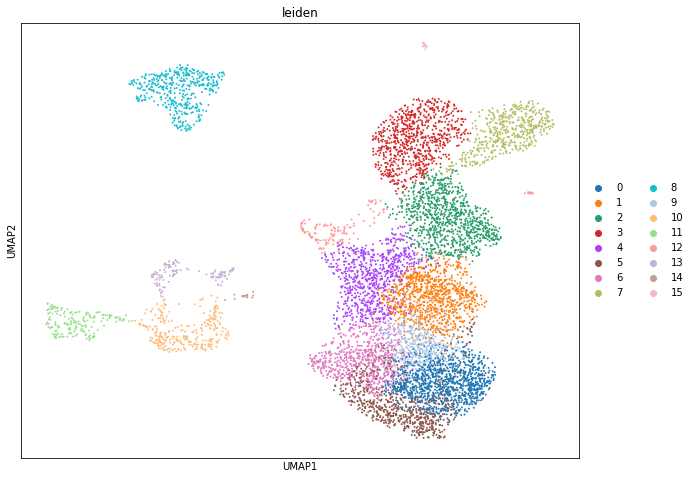

In [ ]:
sc.pl.umap(adata2, color=['leiden'])

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


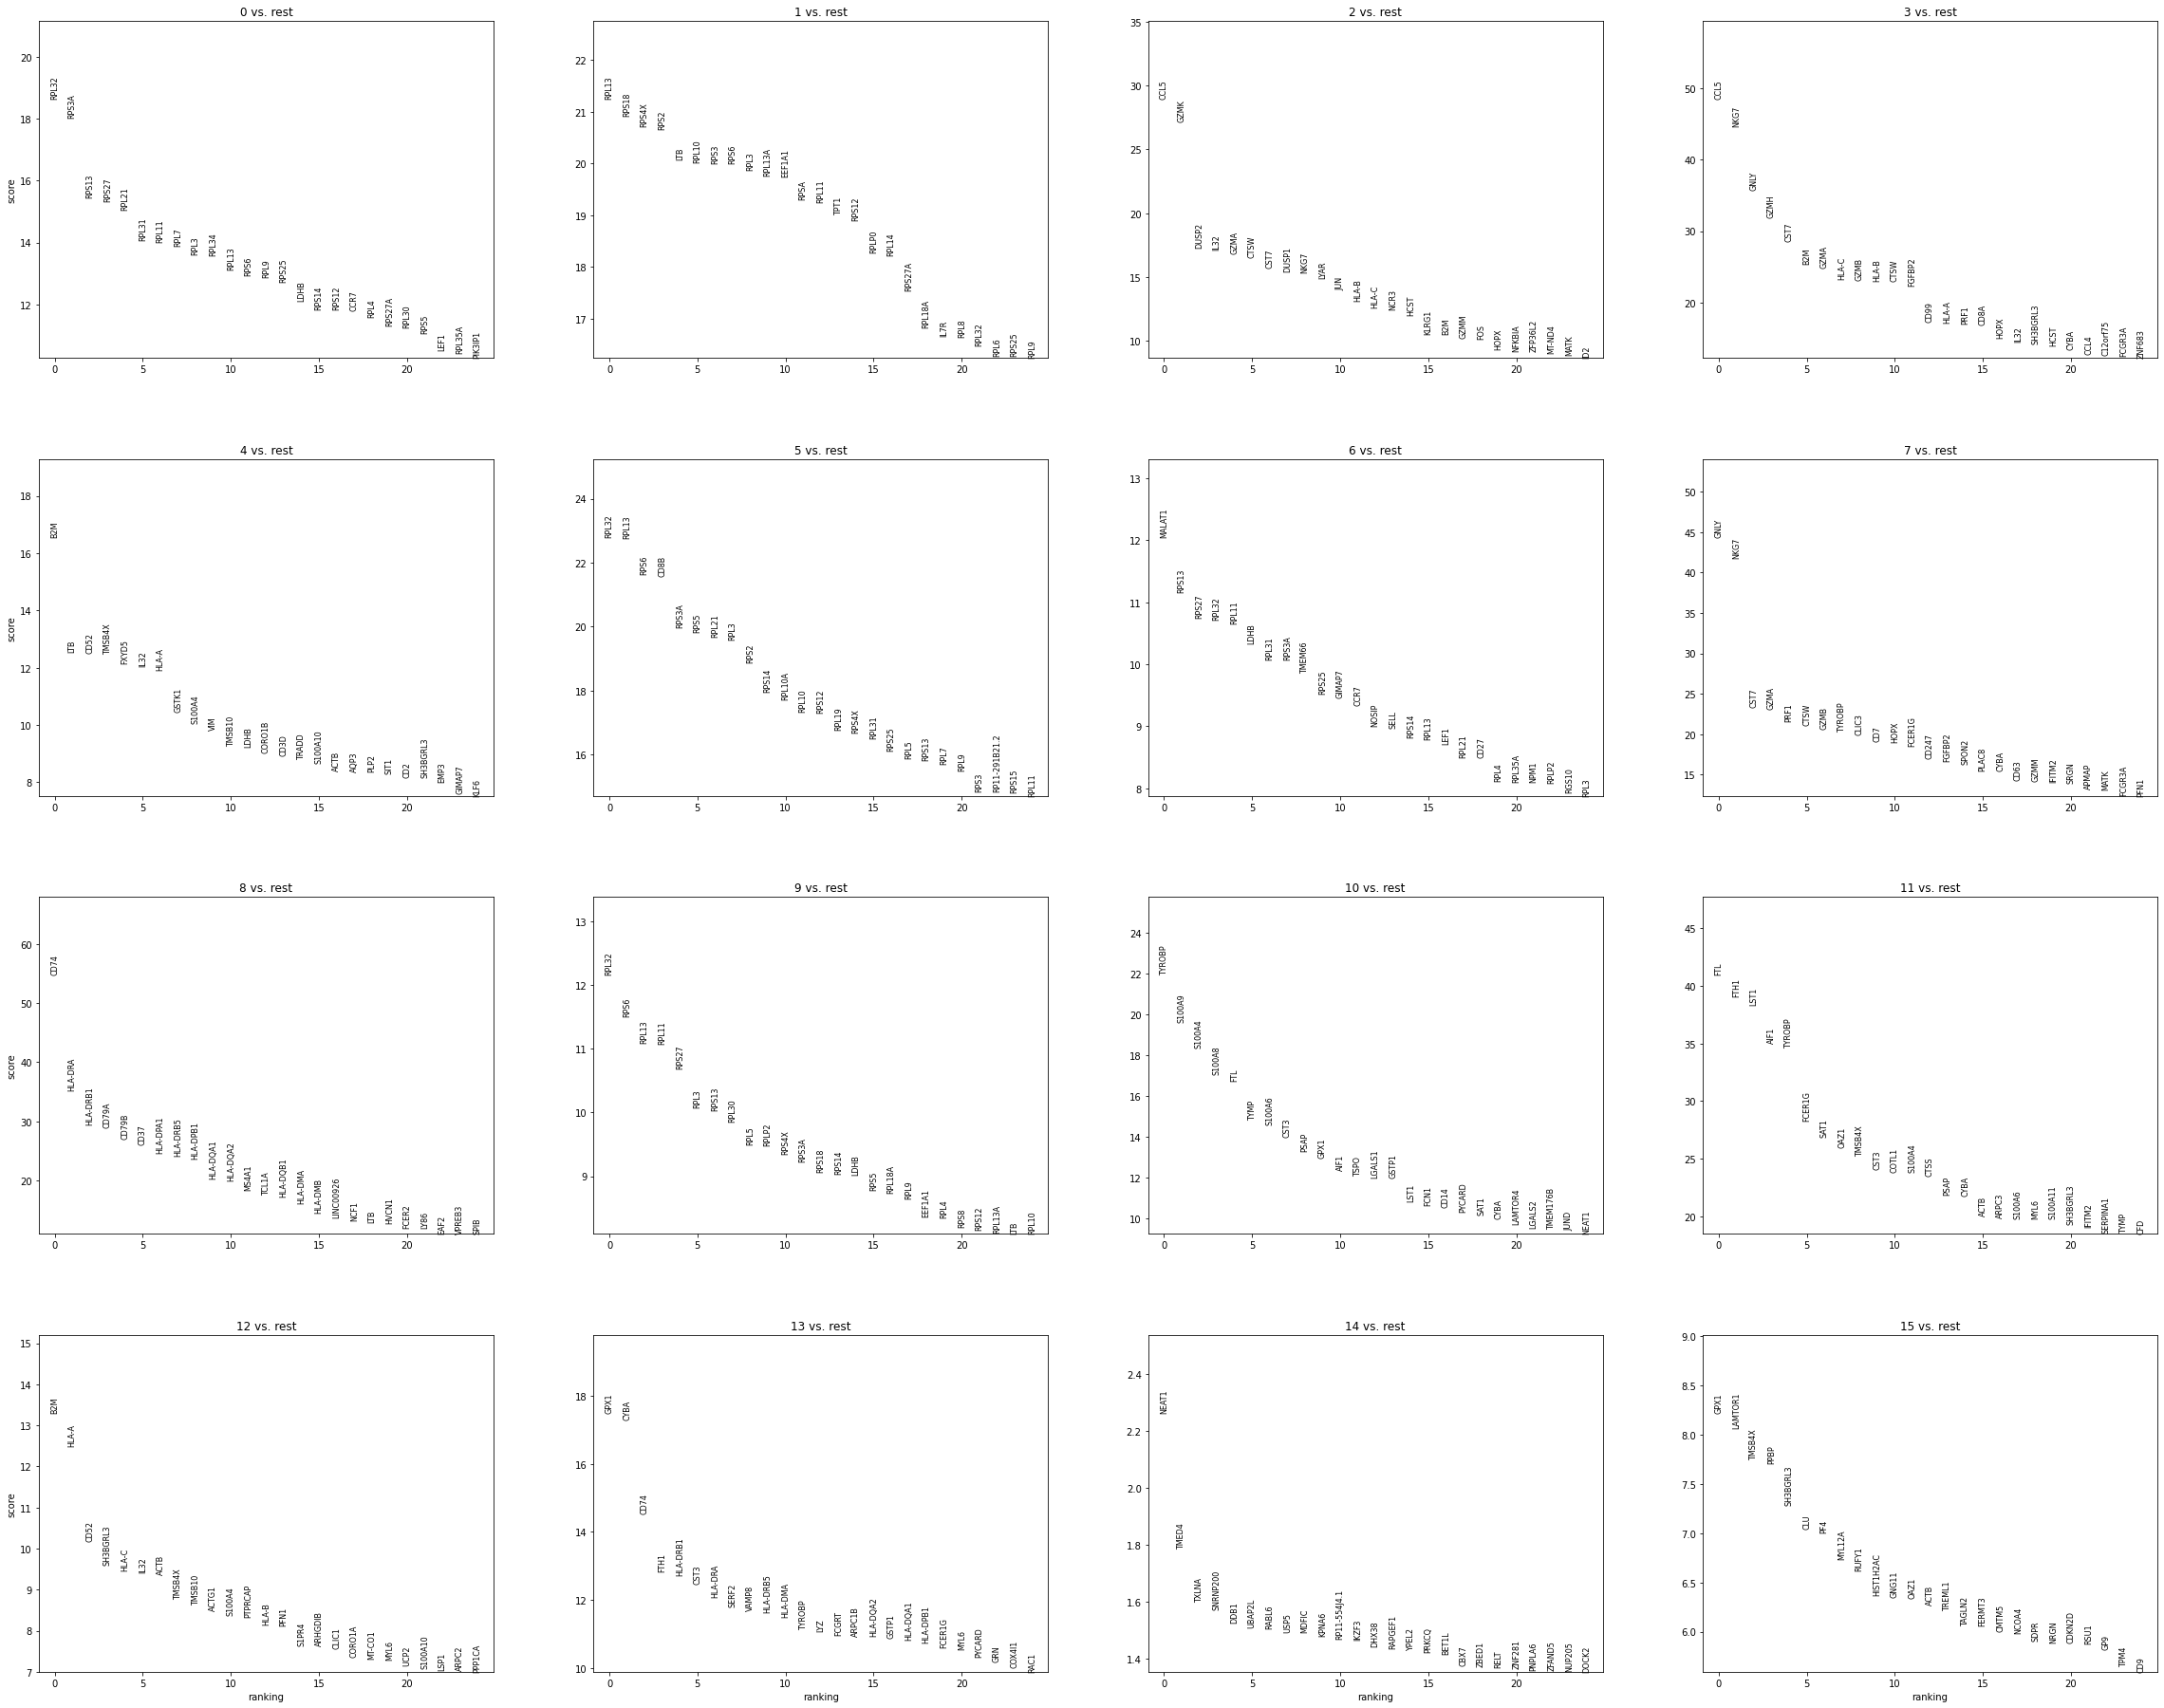

In [ ]:
sc.tl.rank_genes_groups(adata2, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata2, n_genes=25, sharey=False)

### Next, our implementation

In [ ]:
adata.X

array([[0.01825461, 0.01179547, 0.02299262, ..., 0.00833139, 0.07088282,
        0.08868307],
       [0.02777003, 0.00867072, 0.04188032, ..., 0.0184472 , 0.08935869,
        0.1253995 ],
       [0.0177532 , 0.01396261, 0.02509901, ..., 0.00748689, 0.0815018 ,
        0.10517253],
       ...,
       [0.02301361, 0.00884409, 0.01406075, ..., 0.00739302, 0.06550492,
        0.10213827],
       [0.01698229, 0.00657834, 0.0094364 , ..., 0.00392036, 0.04377214,
        0.04037715],
       [0.02158817, 0.003932  , 0.02776583, ..., 0.01196512, 0.05293634,
        0.07745343]], dtype=float32)

In [ ]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [ ]:
# PCA and neighbor graph
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

In [ ]:
# Embed neighbor graph using UMAP
sc.tl.umap(adata)

In [ ]:
# Cluster and visualize
sc.tl.leiden(adata)

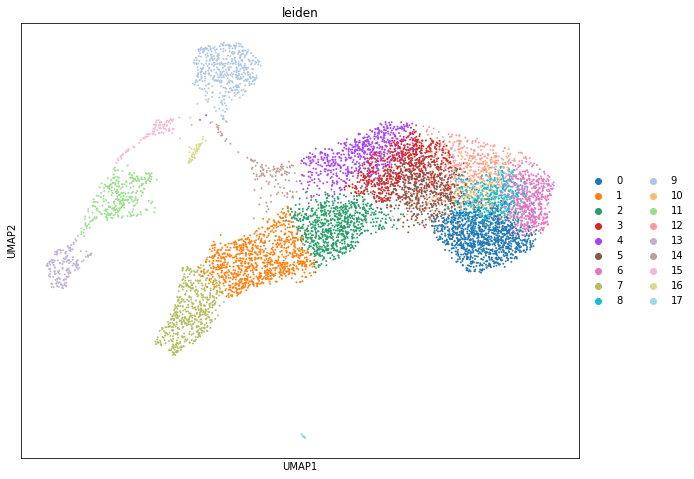

In [ ]:
sc.pl.umap(adata, color=['leiden'])

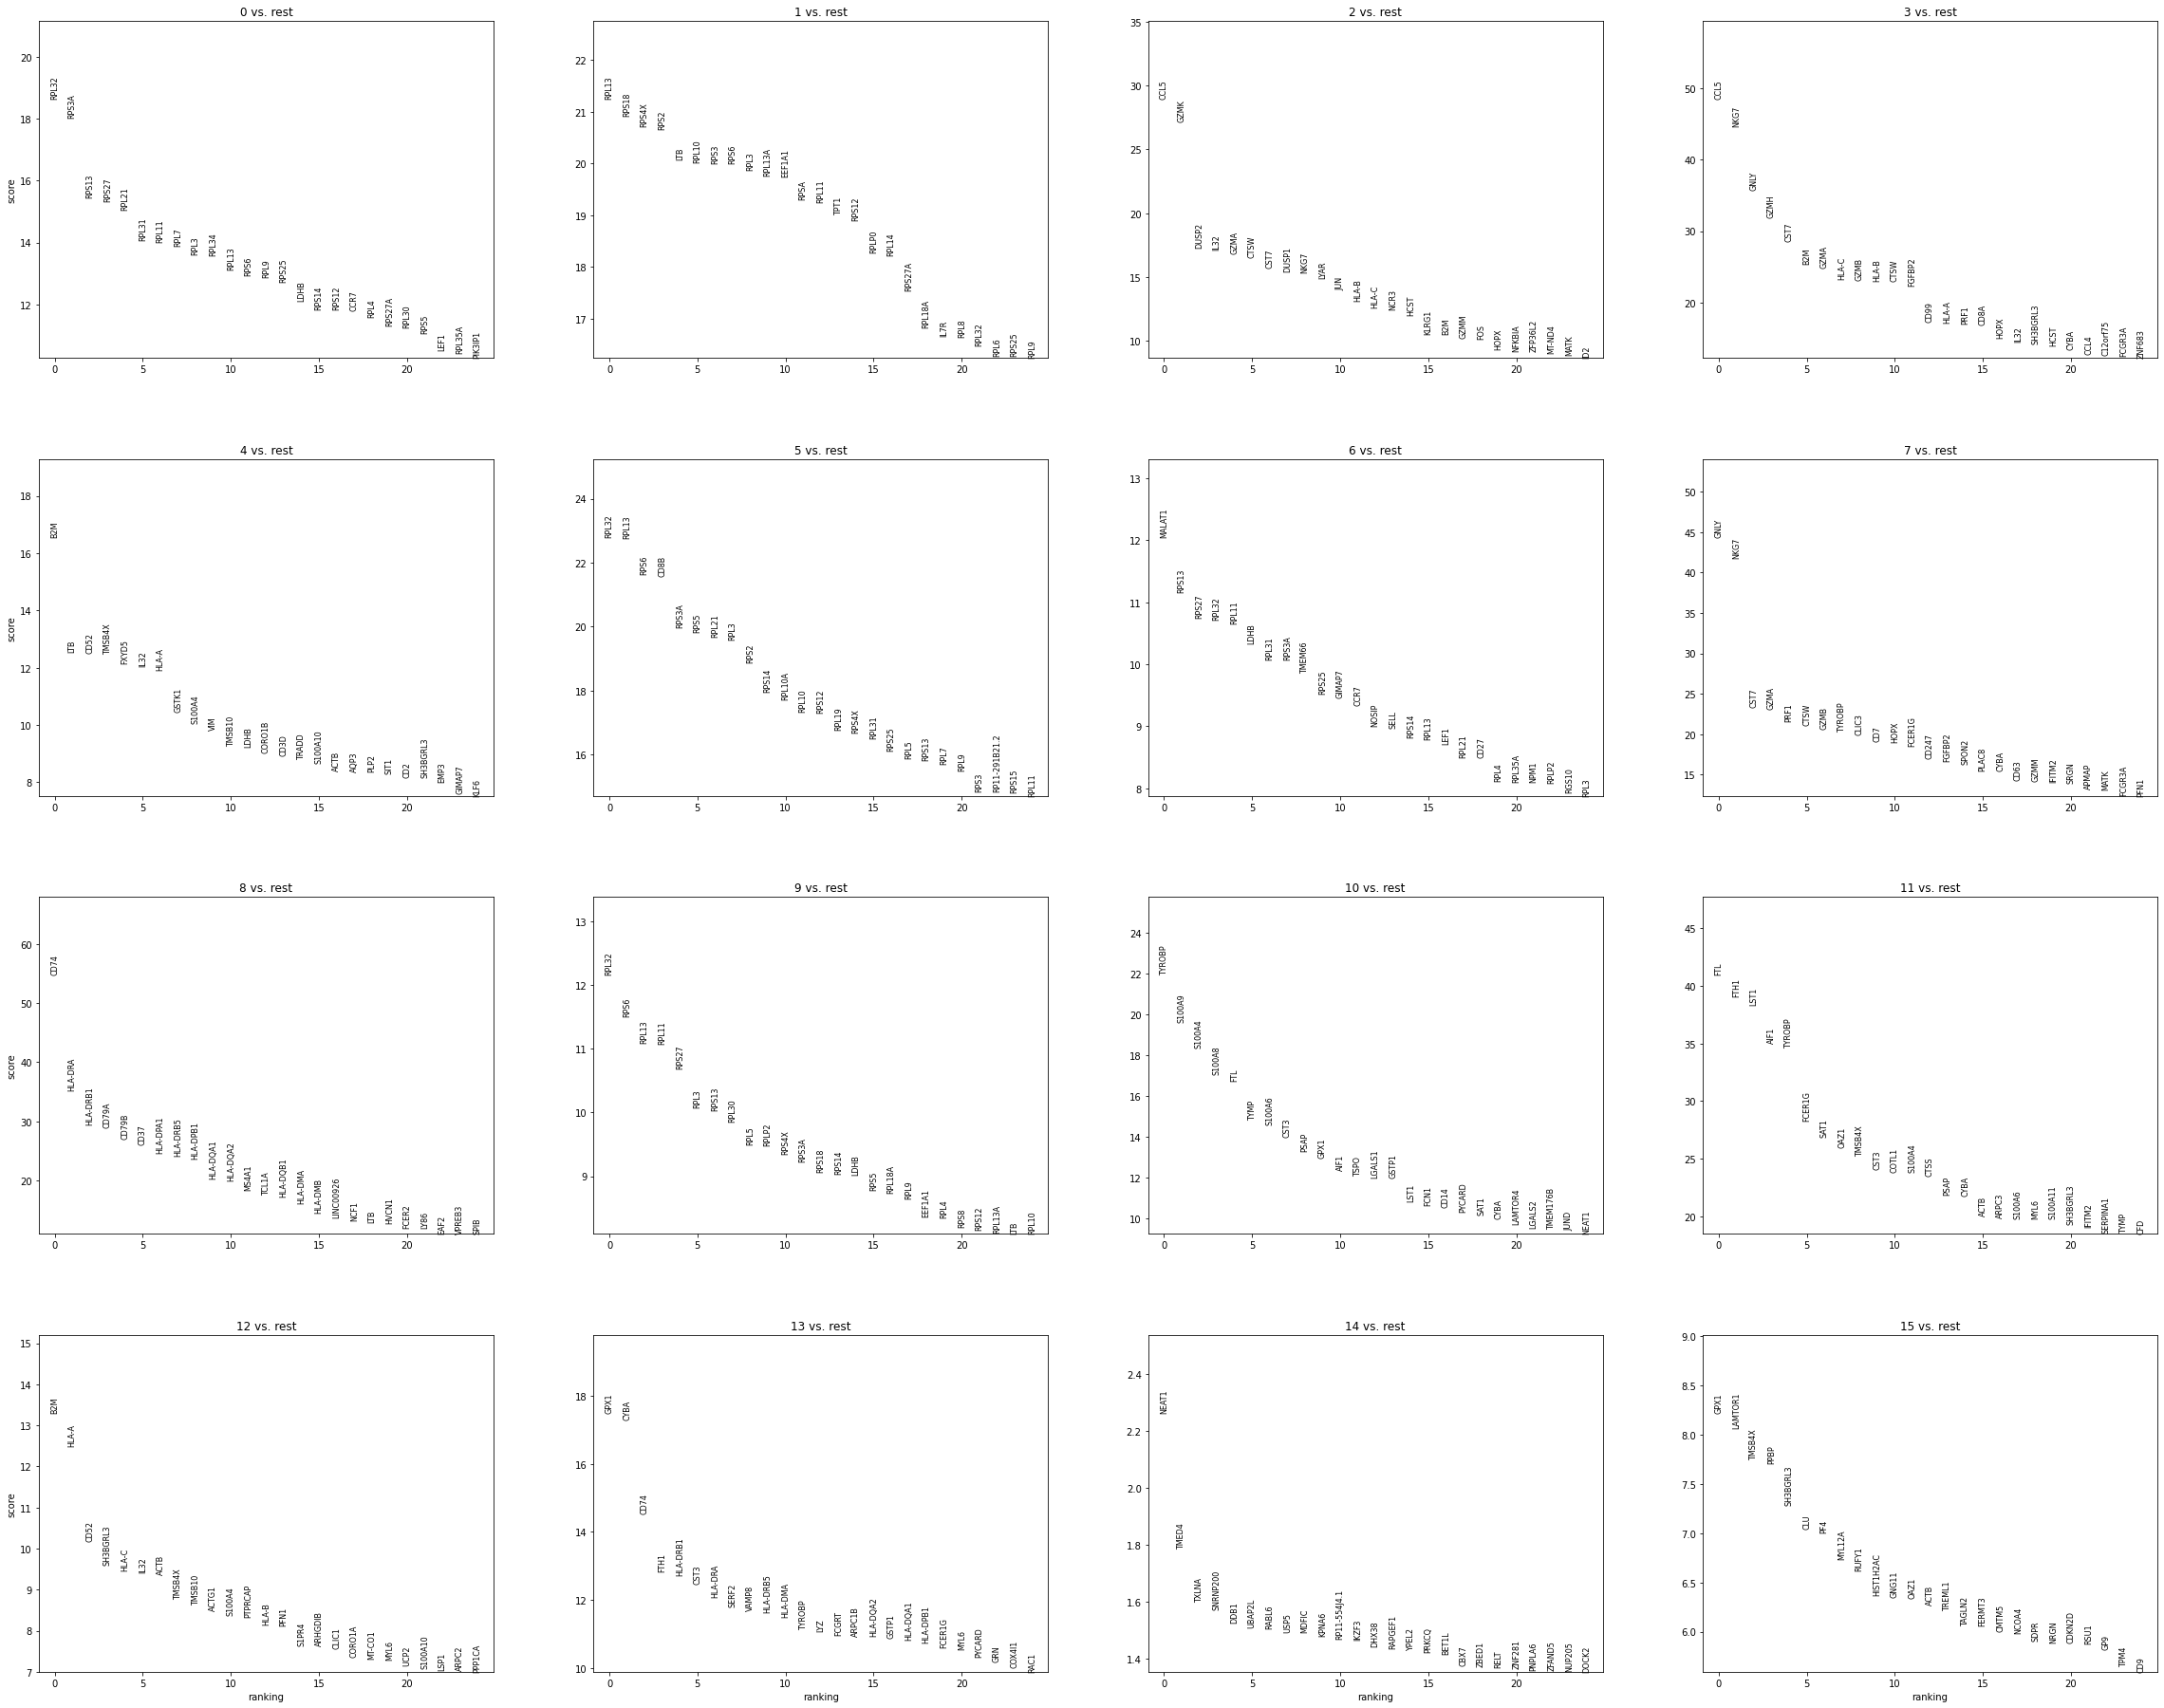

In [ ]:
sc.tl.rank_genes_groups(adata2, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata2, n_genes=25, sharey=False)

In [ ]:
adata2

AnnData object with n_obs × n_vars = 8000 × 16632
    obs: 'n_counts', 'dca_split', 'size_factors', 'leiden'
    var: 'gene_ids', 'n_counts', 'mean', 'std'
    uns: 'log1p', 'dca_loss_history', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'rank_genes_groups'
    obsm: 'X_dca_dispersion', 'X_dca_dropout', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

### Compare with no dropout imputing whatsoever

In [ ]:
adata3 = sc.read_10x_mtx(
    'filtered_matrices_mex/hg19/',  
    var_names='gene_symbols',                
    cache=False)  

adata3 = adata3[indices, ]

In [ ]:
adata3.var_names_make_unique()
sc.pp.filter_genes(adata3, min_counts=1)
sc.pp.filter_cells(adata3, min_counts=1)

In [ ]:
sc.pp.normalize_total(adata3)
sc.pp.log1p(adata3)

In [ ]:
# PCA and neighbor graph
sc.tl.pca(adata3, svd_solver='arpack')
sc.pp.neighbors(adata3, n_neighbors=10, n_pcs=40)

In [ ]:
# Embed neighbor graph using UMAP
sc.tl.umap(adata3)

In [ ]:
# Cluster and visualize
sc.tl.leiden(adata3)

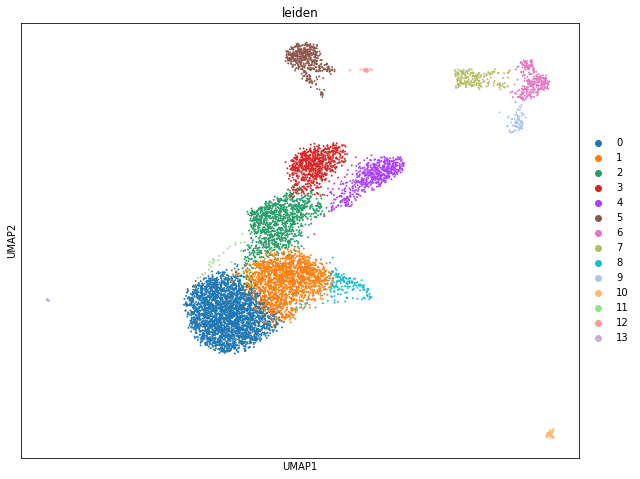

In [ ]:
sc.pl.umap(adata3, color=['leiden'])

In [ ]:
test_df = pd.read_csv('68k_pbmc_barcodes_annotation.tsv', delimiter='\t')

In [ ]:
cd4_list = ['CD4+ T Helper2', 'CD4+/CD25 T Reg', 'CD4+/CD45RA+/CD25- Naive T', 'CD4+/CD45RO+ Memory']
cd8_list = ['CD8+ Cytotoxic T', 'CD8+/CD45RA+ Naive Cytotoxic']

... storing 'cell_type' as categorical


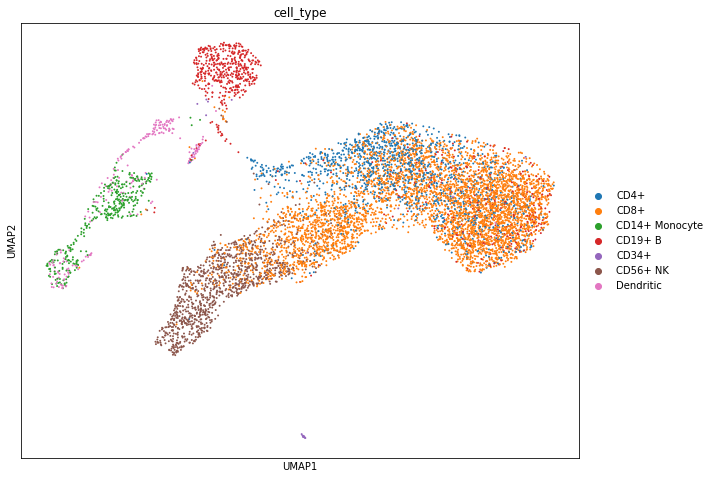

In [ ]:
adata.obs['cell_type'] = test_df['celltype'][indices ].values
adata.obs.loc[adata.obs['cell_type'].isin(cd4_list), 'cell_type'] = 'CD4+'
adata.obs.loc[adata.obs['cell_type'].isin(cd8_list), 'cell_type'] = 'CD8+'
sc.pl.umap(adata, color=['cell_type'])

... storing 'cell_type' as categorical


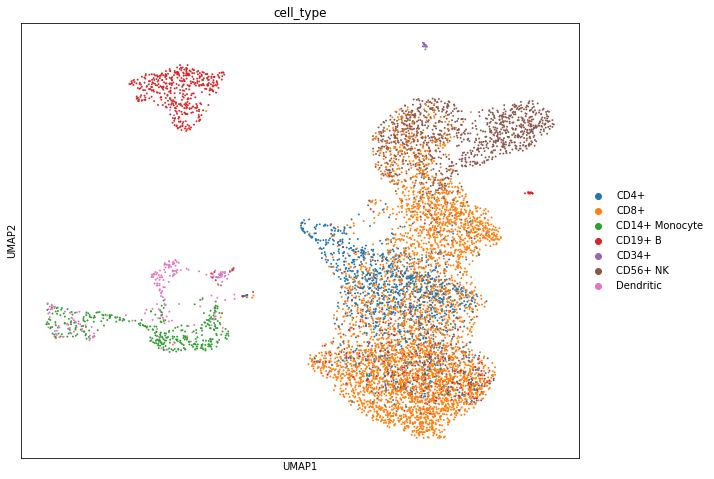

In [ ]:
adata2.obs['cell_type'] = test_df['celltype'][indices ].values
adata2.obs.loc[adata2.obs['cell_type'].isin(cd4_list), 'cell_type'] = 'CD4+'
adata2.obs.loc[adata2.obs['cell_type'].isin(cd8_list), 'cell_type'] = 'CD8+'
sc.pl.umap(adata2, color=['cell_type'])

... storing 'cell_type' as categorical


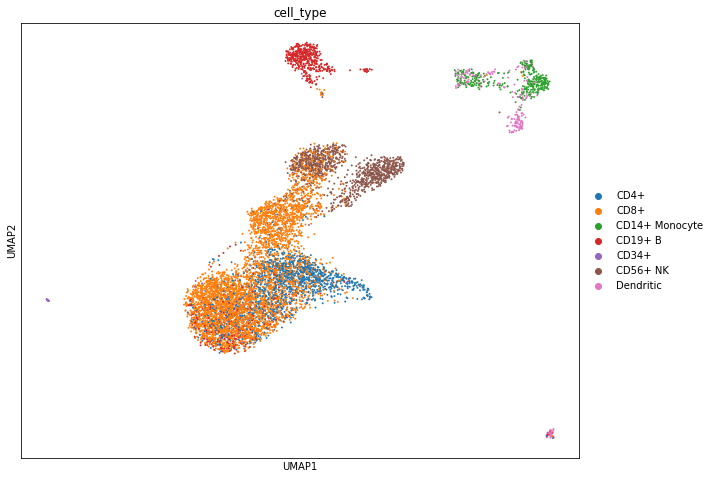

In [ ]:
adata3.obs['cell_type'] = test_df['celltype'][indices ].values
adata3.obs.loc[adata3.obs['cell_type'].isin(cd4_list), 'cell_type'] = 'CD4+'
adata3.obs.loc[adata3.obs['cell_type'].isin(cd8_list), 'cell_type'] = 'CD8+'
sc.pl.umap(adata3, color=['cell_type'])

## Another example -

In [7]:
adata_csv = sc.read_csv('test.csv')

In [9]:
adata_csv.var_names_make_unique()

In [12]:
sc.pp.normalize_total(adata_csv)
sc.pp.log1p(adata_csv)

In [16]:
sc.tl.pca(adata_csv, svd_solver='arpack')

In [17]:
sc.pp.neighbors(adata_csv, n_neighbors=10, n_pcs=40)

In [18]:
sc.tl.umap(adata_csv)

In [20]:
sc.tl.leiden(adata_csv)

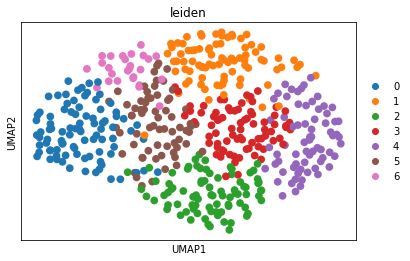

In [22]:
sc.pl.umap(adata_csv, color=['leiden'])

In [47]:
# Now to test out dropout imputation
adata_csv_imp = sc.read_csv('test.csv')

In [48]:
# Do preprocessing on the raw count matrix
sc.pp.filter_genes(adata_csv_imp, min_counts=1)
sc.pp.filter_cells(adata_csv_imp, min_counts=1)

adata_csv_imp.raw = adata_csv_imp.copy()

sc.pp.normalize_total(adata_csv_imp, inplace=True)
adata_csv_imp.obs['size_factors'] = adata_csv_imp.obs.n_counts / np.median(adata_csv_imp.obs.n_counts)

sc.pp.log1p(adata_csv_imp)
sc.pp.scale(adata_csv_imp)

In [49]:
n_cells, n_genes = adata_csv_imp.n_obs, adata_csv_imp.n_vars

In [50]:
count_mtx = torch.tensor(adata_csv_imp.X)
size_factor = torch.tensor(adata_csv_imp.obs.size_factors.values)
count_mtx_raw = torch.tensor(adata_csv_imp.raw.X)

In [51]:
dataset = TensorDataset(count_mtx, size_factor, count_mtx_raw)

In [52]:
train_dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [53]:
learning_rate = 1e-3
batch_size = 32
epochs = 50
grad_clip_val = 5.0

In [54]:
model = ZINB_Autoencoder(n_genes, (64, 32, 64))
model.apply(weights_init)

ZINB_Autoencoder(
  (autoencoder_stack): Sequential(
    (0): Linear(in_features=3000, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=0.001, momentum=0.1, affine=False, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): BatchNorm1d(32, eps=0.001, momentum=0.1, affine=False, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=64, bias=True)
    (7): BatchNorm1d(64, eps=0.001, momentum=0.1, affine=False, track_running_stats=True)
    (8): ReLU()
  )
  (mean): Sequential(
    (0): Linear(in_features=64, out_features=3000, bias=True)
    (1): mean_activation()
  )
  (theta): Sequential(
    (0): Linear(in_features=64, out_features=3000, bias=True)
    (1): disp_activation()
  )
  (pi): Sequential(
    (0): Linear(in_features=64, out_features=3000, bias=True)
    (1): Sigmoid()
  )
)

In [55]:
zb_loss_fn = ZINB_Loss()

optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, epochs / 3)

In [56]:
for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train_loop(train_dataloader, model, zb_loss_fn, optimizer)

  scheduler.step()

Epoch 1
-------------------------------
loss: 5.658958911895752 for batch 0/500
Epoch 2
-------------------------------
loss: 2.7823307514190674 for batch 0/500
Epoch 3
-------------------------------
loss: 2.568214178085327 for batch 0/500
Epoch 4
-------------------------------
loss: 2.384411334991455 for batch 0/500
Epoch 5
-------------------------------
loss: 2.3076188564300537 for batch 0/500
Epoch 6
-------------------------------
loss: 2.283543586730957 for batch 0/500
Epoch 7
-------------------------------
loss: 2.2782182693481445 for batch 0/500
Epoch 8
-------------------------------
loss: 2.2427637577056885 for batch 0/500
Epoch 9
-------------------------------
loss: 2.2014875411987305 for batch 0/500
Epoch 10
-------------------------------
loss: 2.1736247539520264 for batch 0/500
Epoch 11
-------------------------------
loss: 2.1638662815093994 for batch 0/500
Epoch 12
-------------------------------
loss: 2.151796340942383 for batch 0/500
Epoch 13
---------------------

In [57]:
mean, theta, pi = model(count_mtx, size_factor)
adata_csv_imp.X = mean.detach().numpy()

In [58]:
sc.pp.normalize_total(adata_csv_imp)
sc.pp.log1p(adata_csv_imp)

In [59]:
sc.tl.pca(adata_csv_imp, svd_solver='arpack')

In [60]:
sc.pp.neighbors(adata_csv_imp, n_neighbors=10, n_pcs=40)

In [61]:
sc.tl.umap(adata_csv_imp)

In [62]:
sc.tl.leiden(adata_csv_imp)

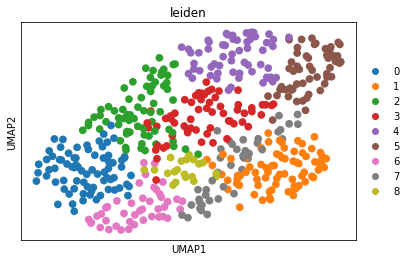

In [63]:
sc.pl.umap(adata_csv_imp, color=['leiden'])

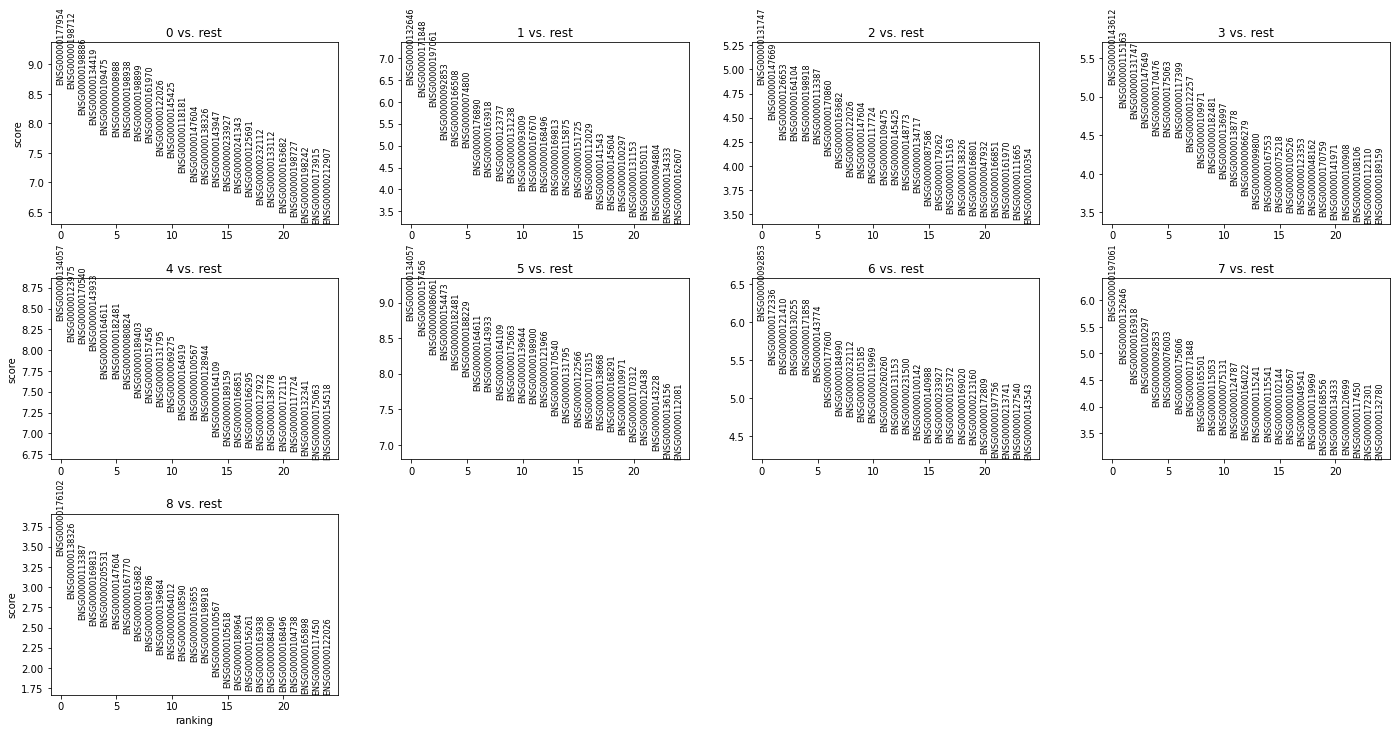

In [84]:
sc.tl.rank_genes_groups(adata_csv_imp, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata_csv_imp, n_genes=25, sharey=False)

In [85]:
pd.DataFrame(adata_csv_imp.uns['rank_genes_groups']['names']).head(10)

,0,1,2,3,4,5,6,7,8
0,ENSG00000177954,ENSG00000132646,ENSG00000131747,ENSG00000143612,ENSG00000134057,ENSG00000134057,ENSG00000092853,ENSG00000197061,ENSG00000176102
1,ENSG00000198712,ENSG00000171848,ENSG00000147669,ENSG00000115163,ENSG00000123975,ENSG00000157456,ENSG00000172336,ENSG00000132646,ENSG00000138326
2,ENSG00000198886,ENSG00000197061,ENSG00000126653,ENSG00000131747,ENSG00000170540,ENSG00000086061,ENSG00000121410,ENSG00000163918,ENSG00000113387
3,ENSG00000134419,ENSG00000092853,ENSG00000164104,ENSG00000147649,ENSG00000143933,ENSG00000154473,ENSG00000130255,ENSG00000100297,ENSG00000169813
4,ENSG00000109475,ENSG00000166508,ENSG00000198918,ENSG00000170476,ENSG00000164611,ENSG00000182481,ENSG00000171858,ENSG00000092853,ENSG00000205531
5,ENSG00000008988,ENSG00000074800,ENSG00000113387,ENSG00000175063,ENSG00000182481,ENSG00000188229,ENSG00000143774,ENSG00000076003,ENSG00000147604
6,ENSG00000198938,ENSG00000176890,ENSG00000170860,ENSG00000117399,ENSG00000080824,ENSG00000164611,ENSG00000177600,ENSG00000175606,ENSG00000167770
7,ENSG00000198899,ENSG00000163918,ENSG00000163682,ENSG00000122257,ENSG00000189403,ENSG00000143933,ENSG00000184990,ENSG00000171848,ENSG00000163682
8,ENSG00000161970,ENSG00000123737,ENSG00000122026,ENSG00000109971,ENSG00000157456,ENSG00000164109,ENSG00000232112,ENSG00000165501,ENSG00000198786
9,ENSG00000122026,ENSG00000131238,ENSG00000147604,ENSG00000182481,ENSG00000131795,ENSG00000175063,ENSG00000105185,ENSG00000115053,ENSG00000139684


## Deep impute example

In [65]:
from deepimpute.multinet import MultiNet

data = pd.read_csv('test.csv',index_col=0)
print('Working on {} cells and {} genes'.format(*data.shape))

Working on 500 cells and 3000 genes


In [66]:
# Using custom parameters
NN_params = {
        'learning_rate': 1e-4,
        'batch_size': 64,
        'max_epochs': 200,
        'ncores': 5,
        'sub_outputdim': 512,
        'architecture': [
            {"type": "dense", "activation": "relu", "neurons": 200},
            {"type": "dropout", "activation": "dropout", "rate": 0.3}]
    }

multinet = MultiNet(**NN_params)

In [67]:
multinet.fit(data, cell_subset=1, minVMR=0.5)

Input dataset is 500 cells (rows) and 3000 genes (columns)
First 3 rows and columns:
                  ENSG00000177954  ENSG00000197756  ENSG00000231500
AATTGTGACTACGA-1            826.0            674.0            694.0
TGACACGATTCGTT-1            617.0            618.0            594.0
TGTCAGGATTGTCT-1            525.0            550.0            540.0
3072 genes selected for imputation
Net 0: 639 predictors, 512 targets
Net 1: 592 predictors, 512 targets
Net 2: 591 predictors, 512 targets
Net 3: 594 predictors, 512 targets
Net 4: 555 predictors, 512 targets
Net 5: 631 predictors, 512 targets
Normalization
Building network
[{'type': 'dense', 'activation': 'relu', 'neurons': 200}, {'type': 'dropout', 'activation': 'dropout', 'rate': 0.3}]
Fitting with 500 cells
Epoch 1/200
8/8 [==============================] - 3s 94ms/step - loss: 30.8702 - dense_6_loss: 4.7492 - dense_7_loss: 5.6277 - dense_8_loss: 4.0849 - dense_9_loss: 5.5961 - dense_10_loss: 5.3027 - dense_11_loss: 5.5096 - val_l

In [68]:
imputedData = multinet.predict(data)

Filling zeros


In [72]:
imputedData.values.shape

(500, 3000)

In [73]:
adata_csv_di = sc.read_csv('test.csv')

In [74]:
adata_csv_di.X = imputedData.values

In [75]:
adata_csv_di.var_names_make_unique()

In [76]:
sc.pp.normalize_total(adata_csv_di)
sc.pp.log1p(adata_csv_di)

In [77]:
sc.tl.pca(adata_csv_di, svd_solver='arpack')

In [78]:
sc.pp.neighbors(adata_csv_di, n_neighbors=10, n_pcs=40)

In [79]:
sc.tl.umap(adata_csv_di)

In [80]:
sc.tl.leiden(adata_csv_di)

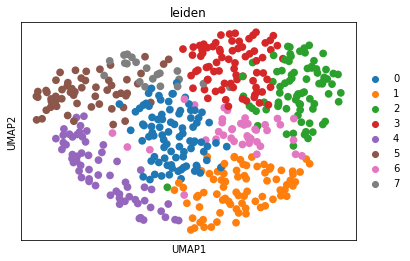

In [81]:
sc.pl.umap(adata_csv_di, color=['leiden'])

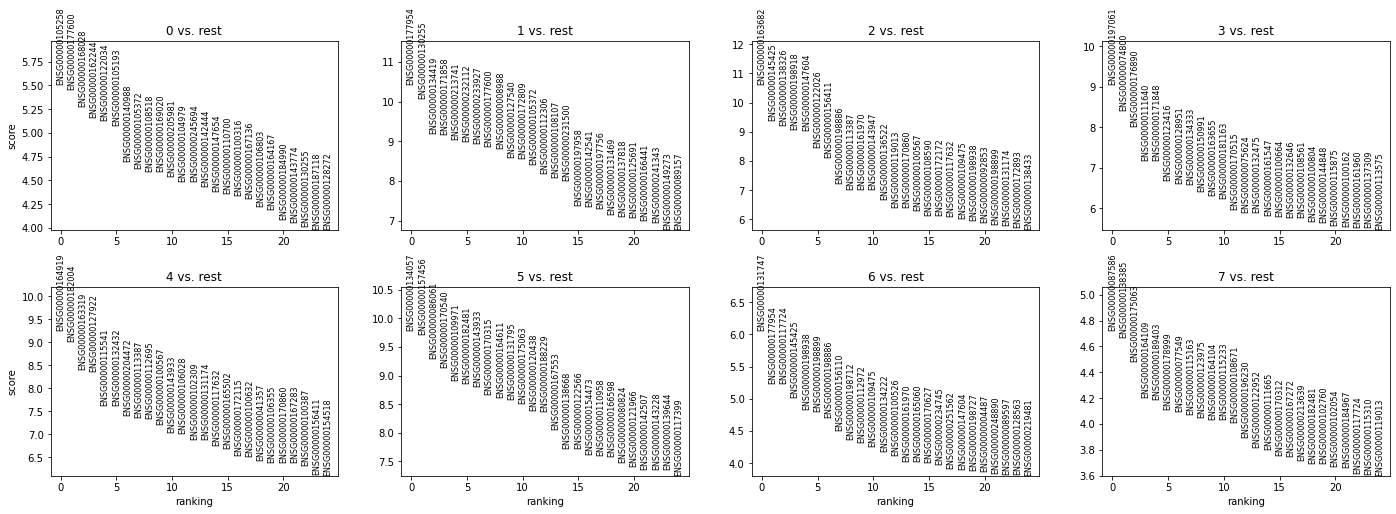

In [83]:
sc.tl.rank_genes_groups(adata_csv_di, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata_csv_di, n_genes=25, sharey=False)

In [86]:
pd.DataFrame(adata_csv_di.uns['rank_genes_groups']['names']).head(10)

,0,1,2,3,4,5,6,7
0,ENSG00000105258,ENSG00000177954,ENSG00000163682,ENSG00000197061,ENSG00000164919,ENSG00000134057,ENSG00000131747,ENSG00000087586
1,ENSG00000177600,ENSG00000130255,ENSG00000145425,ENSG00000074800,ENSG00000182004,ENSG00000157456,ENSG00000177954,ENSG00000138385
2,ENSG00000168028,ENSG00000134419,ENSG00000138326,ENSG00000176890,ENSG00000163319,ENSG00000086061,ENSG00000117724,ENSG00000175063
3,ENSG00000162244,ENSG00000171858,ENSG00000198918,ENSG00000111640,ENSG00000127922,ENSG00000170540,ENSG00000145425,ENSG00000164109
4,ENSG00000122034,ENSG00000213741,ENSG00000147604,ENSG00000171848,ENSG00000115541,ENSG00000109971,ENSG00000198938,ENSG00000189403
5,ENSG00000105193,ENSG00000232112,ENSG00000122026,ENSG00000123416,ENSG00000132432,ENSG00000182481,ENSG00000198899,ENSG00000178999
6,ENSG00000140988,ENSG00000233927,ENSG00000156411,ENSG00000128951,ENSG00000204472,ENSG00000143933,ENSG00000198886,ENSG00000077549
7,ENSG00000105372,ENSG00000177600,ENSG00000198886,ENSG00000134333,ENSG00000113387,ENSG00000170315,ENSG00000156110,ENSG00000115163
8,ENSG00000108518,ENSG00000008988,ENSG00000113387,ENSG00000150991,ENSG00000112695,ENSG00000164611,ENSG00000198712,ENSG00000123975
9,ENSG00000169020,ENSG00000127540,ENSG00000161970,ENSG00000163655,ENSG00000100567,ENSG00000131795,ENSG00000112972,ENSG00000164104
